# Entity-Relationship-Modell

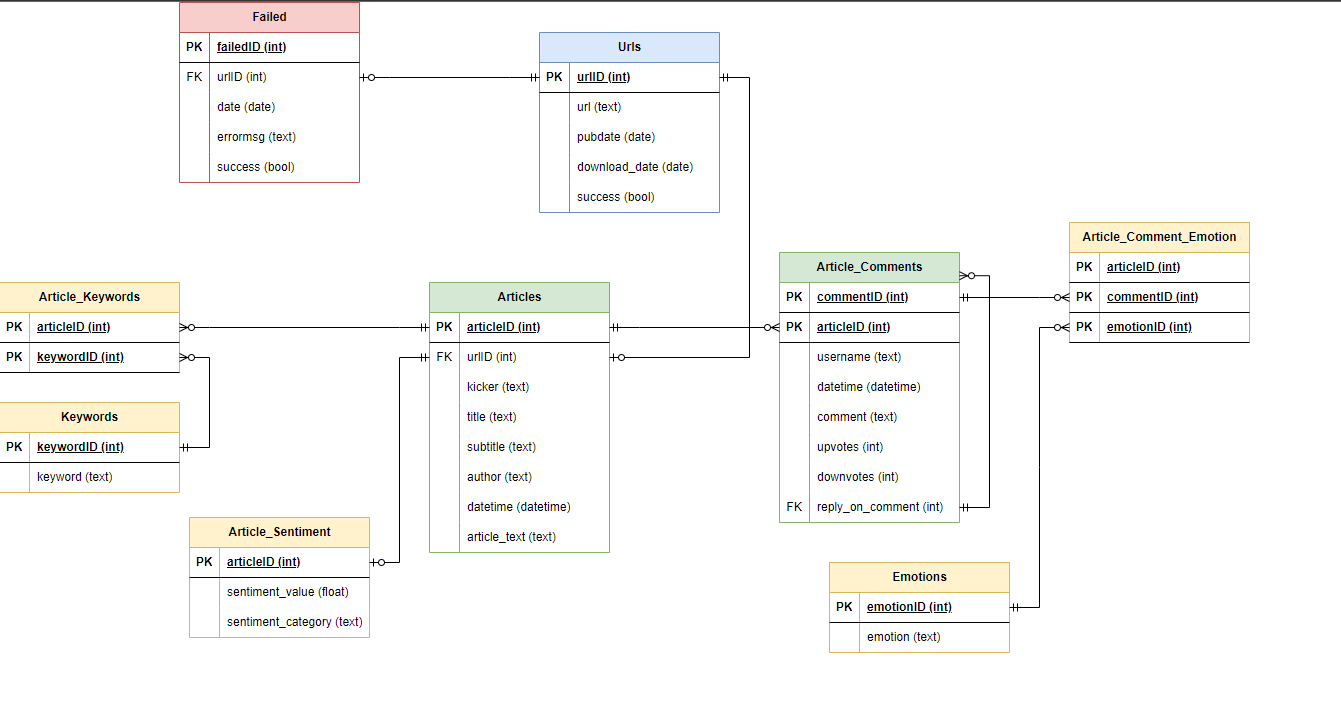

# Feature Extraction

## Tabellen 'Keywords' und 'Article_Keywords' anlegen

In [7]:
import sqlite3

# Verbindung zur SQLite-Datenbank herstellen
conn = sqlite3.connect('derstandard.db')
cursor = conn.cursor()

# Tabelle Keywords erstellen
cursor.execute('''
CREATE TABLE IF NOT EXISTS Keywords (
    keywordID INTEGER PRIMARY KEY AUTOINCREMENT,
    keyword TEXT UNIQUE
)
''')
conn.commit()

# Tabelle Article_Keywords erstellen
cursor.execute('''
CREATE TABLE IF NOT EXISTS Article_Keywords (
    articleID INTEGER,
    keywordID INTEGER,
    PRIMARY KEY (articleID, keywordID),
    FOREIGN KEY(articleID) REFERENCES Articles(articleID),
    FOREIGN KEY(keywordID) REFERENCES Keywords(keywordID)
)
''')
conn.commit()


## Parteien finden

In [14]:
import sqlite3

# Verbindung zur SQLite-Datenbank herstellen
conn = sqlite3.connect('webscraping_derstandard_new.db')
cursor = conn.cursor()

# Tabelle Article_Keywords leeren
cursor.execute('DELETE FROM Article_Keywords')
conn.commit()

print("Die Tabelle 'Article_Keywords' wurde erfolgreich geleert.")

# Verbindung schließen
conn.close()


Die Tabelle 'Article_Keywords' wurde erfolgreich geleert.


In [15]:
import re
import sqlite3
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# Verbindung zur SQLite-Datenbank herstellen
conn = sqlite3.connect('derstandard.db')
cursor = conn.cursor()

# Liste der politischen Parteien und deren mögliche Schreibweisen
parties = {
    'ÖVP': ['ÖVP', 'Oesterreichische Volkspartei', 'Österreichische Volkspartei', 'oevp', 'Volkspartei'],
    'SPÖ': ['SPÖ', 'Sozialdemokratische Partei Österreichs', 'spo', 'SPOE', 'Sozialdemokraten'],
    'FPÖ': ['FPÖ', 'Freiheitliche Partei Österreichs', 'fpoe', 'fpo', 'Freiheitliche'],
    'Grüne': ['Die Grünen', 'Die Gruenen'],
    'NEOS': ['NEOS', 'Das Neue Österreich', 'Neos', 'Liberales Forum'],
    'Liste Pilz': ['Liste Pilz', 'Peter Pilz'],
    'Team Stronach': ['Team Stronach', 'Stronach', 'Frank Stronach'],
    'BZÖ': ['BZÖ', 'Bündnis Zukunft Österreich', 'BZOe'],
    'KPÖ': ['KPÖ', 'Kommunistische Partei Österreichs', 'KPOE', 'kpoe', 'Kommunistische Partei']
}

# Kürzere Liste der Kontextwörter
context_words = [
    'politik', 'partei', 'regierung', 'wahl', 'minister'
]

# Funktion zur Normalisierung der Texte
def normalize_text(text):
    text = text.lower()
    text = text.replace('ä', 'ae').replace('ö', 'oe').replace('ü', 'ue').replace('ß', 'ss')
    return text

# Alle Artikel laden
cursor.execute('SELECT articleID, article_text FROM Articles')
articles = cursor.fetchall()

# Mapping von Keywords zu ihren IDs
keyword_id_mapping = {}

# Vorab die Keywords in die Tabelle Keywords einfügen
for party, spellings in parties.items():
    try:
        cursor.execute('INSERT INTO Keywords (keyword) VALUES (?)', (party,))
        conn.commit()
    except sqlite3.IntegrityError:
        pass  # Keyword existiert bereits

    # Abrufen des keywordID
    cursor.execute('SELECT keywordID FROM Keywords WHERE keyword = ?', (party,))
    keyword_id = cursor.fetchone()[0]
    keyword_id_mapping[party] = keyword_id

# Normalisierung der Kontextwörter
normalized_context_words = [normalize_text(word) for word in context_words]
context_word_set = set(normalized_context_words)

# Durchgehen der Artikel und Suche nach Parteien
for article in articles:
    articleID = article[0]
    article_text = article[1]
    
    # Sicherstellen, dass der Artikeltext vorhanden ist
    if article_text is None:
        continue

    # Normalisieren des Textes für konsistente Suche
    normalized_text = normalize_text(article_text)
    
    # Tokenisierung des Textes
    tokens = word_tokenize(normalized_text)
    
    # Erstellen eines Mapping von Token-Index zu Token
    token_indices = {i: token for i, token in enumerate(tokens)}
    
    token_set = set(tokens)
    
    for party, spellings in parties.items():
        found = False
        for spelling in spellings:
            normalized_spelling = normalize_text(spelling)
            if normalized_spelling in token_set:
                # Finden aller Vorkommen des Keywords im Text
                indices = [i for i, token in token_indices.items() if token == normalized_spelling]
                for index in indices:
                    # Definiere Fenstergröße
                    window_size = 10  # Anzahl der Tokens vor und nach dem Keyword
                    start_index = max(0, index - window_size)
                    end_index = min(len(tokens), index + window_size + 1)
                    window_tokens = tokens[start_index:end_index]
                    # Prüfen, ob ein Kontextwort im Fenster ist
                    if any(context_word in window_tokens for context_word in context_word_set):
                        keywordID = keyword_id_mapping[party]
                        try:
                            cursor.execute('''
                            INSERT INTO Article_Keywords (articleID, keywordID)
                            VALUES (?, ?)
                            ''', (articleID, keywordID))
                            conn.commit()
                        except sqlite3.IntegrityError:
                            pass  # Beziehung existiert bereits
                        found = True
                        break  # Kontextwort gefunden, nicht weiter suchen
                if found:
                    break  # Partei wurde im Artikel gefunden, keine weiteren Schreibweisen prüfen

# Verbindung schließen
conn.close()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sdola\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
import sqlite3
import pandas as pd

# Verbindung zur SQLite-Datenbank herstellen
conn = sqlite3.connect('derstandard.db')

# Liste der aktuell relevanten Parteien
current_parties = ['ÖVP', 'FPÖ', 'NEOS', 'Grüne', 'SPÖ', 'KPÖ']

# Erstellen einer formatgerechten Liste für SQL IN-Klausel
placeholders = ','.join(['?'] * len(current_parties))

# SQL-Abfrage zum Abrufen der Artikel, die eine der aktuellen Parteien behandeln
query = f'''
SELECT DISTINCT a.*
FROM Articles a
JOIN Article_Keywords ak ON a.articleID = ak.articleID
JOIN Keywords k ON ak.keywordID = k.keywordID
WHERE k.keyword IN ({placeholders})
'''

# Ausführen der Abfrage
df_articles = pd.read_sql_query(query, conn, params=current_parties)

# Verbindung schließen
conn.close()

# Einen Blick auf die geladenen Artikel werfen
df_articles


,articleID,urlID,kicker,title,subtitle,author,datetime,article_text
0,719,719,Diskurs,SPÖ auf der falschen Seite?,Ex-Kanzler Franz Vranitzky antwortet Hans Raus...,,1999-04-23 20:02:00,"Wäre Hans Rauschers Vorwurf an die SPÖ, sich i..."
1,896,896,Diskurs,Exekution des Bannfluchs,Die Abschiebepraxis fußt auf einem ignoranten ...,Freda Meissner-Blau,1999-05-18 19:32:00,"Erstickt. In Panik, nach Luft ringend. Der g..."
2,897,897,Diskurs,Schwarze und blaue Aggression,Zu den Vorverurteilungen Helene Partik-Pablés:,,1999-05-18 19:32:00,Etwa sieben Jahre verbrachte ich in 15 afrikan...
3,935,935,Diskurs,Frühling der Katastrophen,,,1999-05-20 21:45:00,"Wer in die Woge der Ereignisse eintaucht, risk..."
4,1072,1072,Diskurs,Gedenken an die Zukunft?,Mauthausen und die FPÖ: Es geht nicht nur um H...,,1999-06-07 19:01:00,"Österreich ist bereit, für die Verbrechen des ..."
...,...,...,...,...,...,...,...,...
77457,491458,1775722,Besuch,Wenig Zeit zum Feiern für Schallenberg in Ankara,Zwei Jubiläen verbinden Österreich und die Tür...,Florian Niederndorfer,2024-05-13 06:00:00,"Sechs Jahrzehnte ist es her, dass die sogenann..."
77458,491461,1775727,Europa,Spaniens Senat lehnt Amnestiegesetz für Katalo...,Die Konservativen blockierten mit ihrer Mehrhe...,,2024-05-14 22:14:00,Madrid/Barcelona – Die konservative Volksparte...
77459,491496,1775766,Unpopulär,Ursula von der Leyen fast allein in Rom,Auf ihrer Wahlkampf-Europatour wurde die EU-Ko...,Dominik Straub,2024-05-14 16:09:00,Ursula von der Leyen hat in Rom schon wärmere ...
77460,491505,1775775,Krisenkommunikation,Ein rotes Telefon zwischen Europa und dem Prob...,Der direkte Draht solle vordergründig der Terr...,Kim Son HoangFabian Sommavilla,2024-05-14 15:30:00,"Ein neues rotes Telefon, das ist der Wunsch vo..."


In [2]:
import datetime
import sqlite3
from bs4 import BeautifulSoup
import pandas as pd
from selenium import webdriver as wd
from selenium.webdriver.chrome.service import Service
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time

# global vars for local system
BASEPATH = r"C:\Users\sdola\Nextcloud\Technikum\NLP\Project"
TRACKER_FILE = rf"{BASEPATH}\derstandard_tracker.txt"
SQLITE_DATABASE = rf"{BASEPATH}\webscraping_derstandard.db"
CHROMEDRIVER_PATH = r"C:\Users\sdola\Documents\chromedriver-win64\chromedriver.exe"
FRONTPAGE_URL = "https://www.derstandard.at/frontpage/"

def read_sqlite_db(path_to_db, query):
    try:
        # Verbindung zur Datenbank herstellen
        conn = sqlite3.connect(path_to_db)
        
        # Abfrage ausführen und Ergebnisse in DataFrame speichern
        df = pd.read_sql_query(query, conn)
        
        return df

    except sqlite3.Error as e:
        print(f"Fehler beim Auslesen der Datenbank: {e}")
        return None

    finally:
        # Verbindung schließen
        if conn:
            conn.close()


In [3]:
# Notwendige Bibliotheken importieren
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

# NLTK-Daten herunterladen (falls noch nicht geschehen)
nltk.download("punkt")

# SQL-Abfrage, um alle Daten abzurufen
query = 'SELECT * FROM articles'

# Daten einlesen
df = read_sqlite_db(SQLITE_DATABASE, query)

# Einen Blick auf die ersten Zeilen werfen
df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sdola\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,url,kicker,title,subtitle,author,datetime,article_text
0,/story/13442/eu-plant-ueberwachungsaktionen-be...,Netzpolitik,EU plant Überwachungsaktionen bei Handys und i...,Kontrolle besonders bei Satellitenkommunikation,None,None,
1,/story/12479/minispion-in-netscapes-navigator-...,Netzpolitik,'Minispion' in Netscapes Navigator eingebaut,Browser erstellt heimlich Persönlichkeitsprofile,None,None,
2,/story/13356/us-handel-verdient-13-milliarden-...,IT-Business,US-Handel verdient 13 Milliarden Dollar im Web,Firmen investieren 65 Prozent ihrer Erlöse ern...,None,None,
3,/story/13154/studie-dritte-mobilfunkgeneration...,Netzpolitik,Studie: Dritte Mobilfunkgeneration wird Gesell...,"Grenzen zwischen Arbeit und Freizeit, Öffentli...",None,None,
4,/story/13124/details-zum-mega-deal-aol-netscape,IT-Business,Details zum Mega-Deal AOL-Netscape,"AOL kauft Netscape für 4,2 Milliarden US-Dolla...",None,None,


In [4]:
# Fehlende Werte in 'article_text' entfernen
df = df.dropna(subset=['article_text'])

# Funktion zur Berechnung der Wortanzahl
def count_words(text):
    words = word_tokenize(text)
    return len(words)

# Funktion zur Berechnung der durchschnittlichen Wortlänge
def avg_word_length(text):
    words = word_tokenize(text)
    word_lengths = [len(word) for word in words if word.isalpha()]
    if len(word_lengths) > 0:
        return sum(word_lengths) / len(word_lengths)
    else:
        return 0

# Funktion zur Berechnung der Satzanzahl
def count_sentences(text):
    sentences = sent_tokenize(text)
    return len(sentences)

# Neue Features erstellen
df['word_count'] = df['article_text'].apply(count_words)
df['avg_word_length'] = df['article_text'].apply(avg_word_length)
df['sentence_count'] = df['article_text'].apply(count_sentences)

# Ergebnisse anzeigen
df[['title', 'word_count', 'avg_word_length', 'sentence_count']].head()

,title,word_count,avg_word_length,sentence_count
0,EU plant Überwachungsaktionen bei Handys und i...,0,0.0,0
1,'Minispion' in Netscapes Navigator eingebaut,0,0.0,0
2,US-Handel verdient 13 Milliarden Dollar im Web,0,0.0,0
3,Studie: Dritte Mobilfunkgeneration wird Gesell...,0,0.0,0
4,Details zum Mega-Deal AOL-Netscape,0,0.0,0


In [ ]:
df